In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os.path as osp
import sys


def add_path(path):
    if path not in sys.path:
        sys.path.insert(0, path)


this_dir = osp.dirname('../../train.py')

lib_path = osp.join(this_dir, 'lib')
add_path(lib_path)

In [2]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

In [3]:
import torch
from utils.dataloader import CERN_Dataset_V3, UMASS_Dataset_V2
from torch.utils.data import DataLoader
from models.models import HAE, AE, SCSAE, HAE_V2

In [4]:
ae_48_cern = "../../model_param/state_1930060.pt"
hae_48_cern = "../../model_param/state_7218799.pt"
scsae_48_cern = "../../model_param/state_6603495.pt"

### CER

Load models and dset

In [13]:
ae_model = AE(dropout = 0.1, latent_n = 48, input_days = 12, wide_freq = 48)
ae_model.load_state_dict(torch.load(ae_48_cern)['state_dict'])
ae_model.eval()
hae_model = HAE_V2(latent_n = 48, input_days = 12, wide_freq = 48, reshape_factor = 1, device = 'cpu')
hae_model.load_state_dict(torch.load(hae_48_cern)['state_dict'])
hae_model.eval()
scsae_model = SCSAE(latent_n = 48, input_days = 12, wide_freq = 48, reshape_factor = 2)
scsae_model.load_state_dict(torch.load(scsae_48_cern)['state_dict'])
scsae_model.eval()
print('loaded')

loaded


In [14]:
ae_test_set = CERN_Dataset_V3(train = False, no_days = 12, reshape_factor = 2, mode = 'fc')
hae_test_set = CERN_Dataset_V3(train = False, no_days = 12, reshape_factor = 1, mode = 'cnn')
scsae_test_set = CERN_Dataset_V3(train = False, no_days = 12, reshape_factor = 2, mode = 'cnn')
ae_loader = DataLoader(ae_test_set, batch_size = 1)
hae_loader = DataLoader(hae_test_set, batch_size = 1)
scsae_loader = DataLoader(scsae_test_set, batch_size = 1)

100%|██████████| 200/200 [00:00<00:00, 3623.51it/s]


Run models

In [15]:
criterion = torch.nn.MSELoss()
all_mse = pd.DataFrame(columns=['model', 'example', 'mse'])

In [16]:
for i in range(1):
    start_time = time.time()
    losses = []
    for data, data_noise in ae_loader:
        y, _ = ae_model(data)
        loss = criterion(y, data_noise).item()
        losses.append(loss)
    print("--- %s seconds ---" % (time.time() - start_time))
    
all_mse = pd.concat([all_mse, pd.DataFrame({'model':'ae','example':range(1000), 'mse':losses})], axis=0)

--- 0.4656050205230713 seconds ---


In [17]:
for i in range(1):
    start_time = time.time()
    losses = []
    for data, data_noise in hae_loader:
        y, _ = hae_model(data, )
        loss = criterion(y, data_noise).item()
        losses.append(loss)
    print("--- %s seconds ---" % (time.time() - start_time))    

all_mse = pd.concat([all_mse, pd.DataFrame({'model':'hae','example':range(1000), 'mse':losses})], axis=0)

--- 3.8056640625 seconds ---


In [18]:
for i in range(1):
    start_time = time.time()
    losses = []
    for data, data_noise in scsae_loader:
        y, _ = scsae_model(data)
        loss = criterion(y, data_noise).item()
        losses.append(loss)
    print("--- %s seconds ---" % (time.time() - start_time))

all_mse = pd.concat([all_mse, pd.DataFrame({'model':'scsae','example':range(1000), 'mse':losses})], axis=0)

--- 1.4417815208435059 seconds ---


In [19]:
all_mse = all_mse.reset_index(drop=True)
all_mse = all_mse.pivot(index='example', columns='model', values='mse')

/scratch/au31/scotty/miniconda/conda/envs/jupyterlab/lib/python3.9/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


In [20]:
# best examples
(all_mse.hae - all_mse.scsae).sort_values()[:5]

example
982   -0.012024
374   -0.011642
981   -0.010662
372   -0.009036
373   -0.007951
dtype: object

In [21]:
# worst examples
(all_mse.hae - all_mse.scsae).sort_values(ascending=False)[:5]

example
742    0.011124
741    0.010969
743    0.008379
744    0.005205
985    0.003648
dtype: object

##### Show examples

In [47]:
def show_example(record, models = ['SCSAE', 'CRAE'], name='default'):
    
    test_record_ae = ae_test_set.cern_data[record]
    test_record_scsae = scsae_test_set.cern_data[record]
    test_record_hae = hae_test_set.cern_data[record]

    test_record_orig = test_record_ae.numpy()
    
    ae_test_out, _ = ae_model(test_record_ae.unsqueeze(0))
    scsae_test_out, _ = scsae_model(test_record_scsae.unsqueeze(0))
    hae_test_out, _ = hae_model(test_record_hae.unsqueeze(0))

    ae_test_out = ae_test_out.reshape(576).detach().numpy()
    scsae_test_out = scsae_test_out.reshape(576).detach().numpy()
    hae_test_out = hae_test_out.reshape(576).detach().numpy()
    
    fig, ax = plt.subplots(figsize=(14,6))

    for i in range(0, 576+48, 48):
        ax.axvline(x=i, color='black', alpha=.2)

    if 'AE' in models: ax.plot(ae_test_out, label='AE')
    if 'SCSAE' in models: ax.plot(scsae_test_out, '-r', label='SCSAE', alpha=1, linewidth=1)
    if 'CRAE' in models: ax.plot(hae_test_out, '-g', label='CRAE', alpha=1)
    ax.plot(test_record_orig, '-m', label='Original', alpha=.6)
    ax.legend()
    mses_ = {'SCSAE': all_mse.loc[record].scsae, 'CRAE': all_mse.loc[record].hae,
            'AE': all_mse.loc[record].ae}
    title = '{}. \nMSE -- '.format(name) + str(', '.join([k + ': ' + '{:.4f}'.format(v) for k, v in mses_.items() if k in models]))
    ax.set_title(title)
    plt.show()

In [59]:
def download_examples(records):

    all_examples = pd.DataFrame()
    
    for record in records:

        test_record_scsae = scsae_test_set.cern_data[record]
        test_record_hae = hae_test_set.cern_data[record]
        test_record_orig = ae_test_set.cern_data[record].numpy()
        scsae_test_out, _ = scsae_model(test_record_scsae.unsqueeze(0))
        hae_test_out, _ = hae_model(test_record_hae.unsqueeze(0))
        scsae_test_out = scsae_test_out.reshape(576).detach().numpy()
        hae_test_out = hae_test_out.reshape(576).detach().numpy()

        new_df = pd.DataFrame({'SCSAE': scsae_test_out, 'CRAE': hae_test_out, 'Original': test_record_orig, 'Index': range(576), 'record': record})

        all_examples = pd.concat([all_examples, new_df])

    return all_examples

In [63]:
download_examples([741, 742, 743, 982, 374, 981]).to_csv('../../summary_results/examples.csv', index=False)

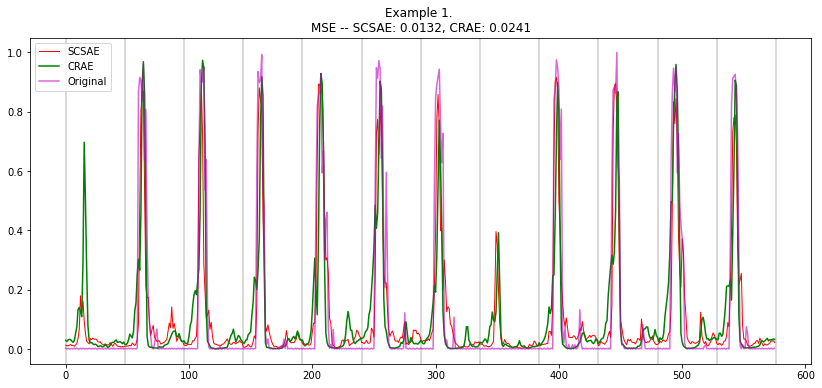

In [42]:
show_example(741, ['SCSAE', 'CRAE'], 'Example 1')

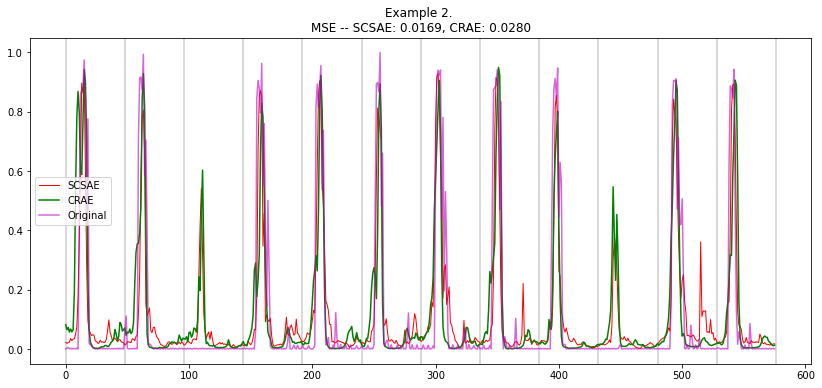

In [44]:
show_example(742, ['SCSAE', 'CRAE'], 'Example 2')

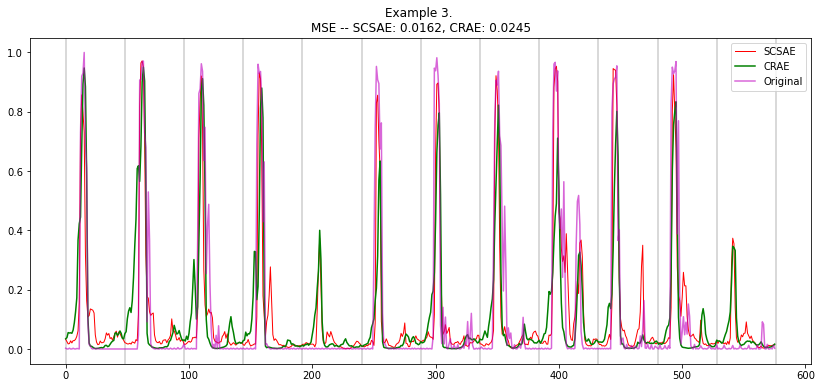

In [45]:
show_example(743, ['SCSAE', 'CRAE'], 'Example 3')

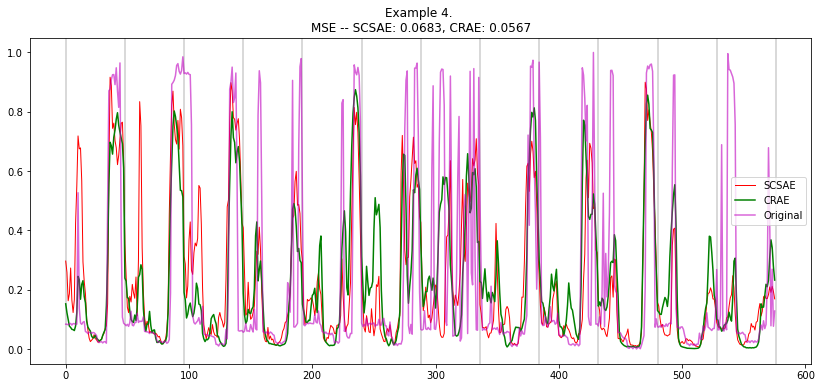

In [48]:
show_example(374, name = 'Example 4')

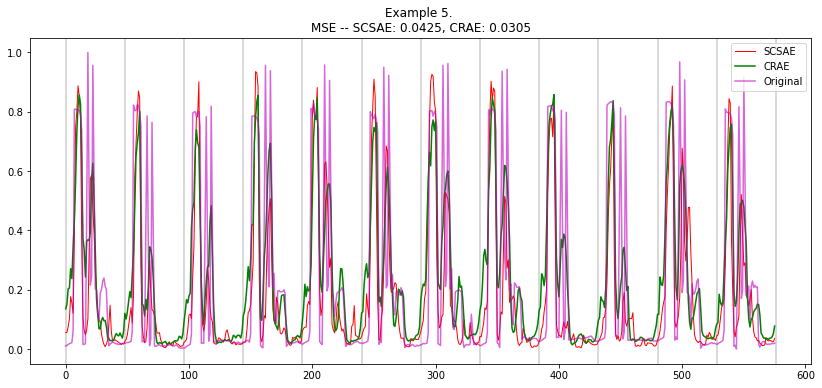

In [49]:
show_example(982, name = 'Example 5')

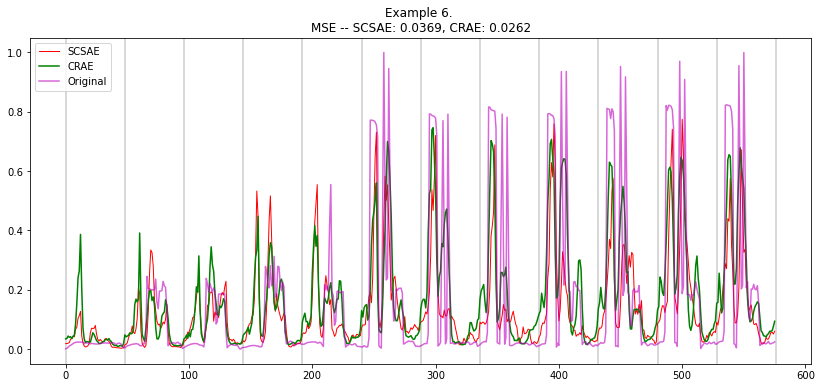

In [50]:
show_example(981, name = 'Example 6')

Compared against normal AE

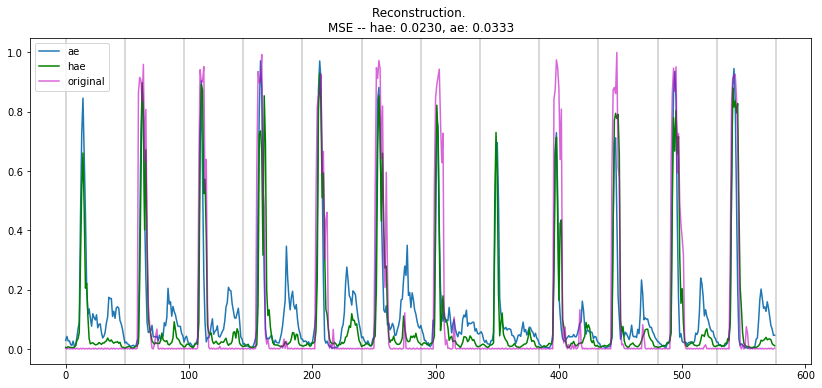

In [298]:
show_example(741, ['ae', 'hae'])

#### Show Distributions

In [250]:
all_mse_

,example,model,value
0,0,ae,0.006534
1,1,ae,0.010770
2,2,ae,0.008000
3,3,ae,0.018982
4,4,ae,0.010293
...,...,...,...
2995,995,scsae,0.010308
2996,996,scsae,0.008361
2997,997,scsae,0.015153
2998,998,scsae,0.019626


<AxesSubplot:xlabel='value', ylabel='Density'>

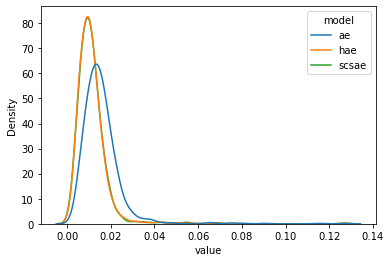

In [257]:
all_mse_ = all_mse.reset_index().melt(id_vars='example')
sns.kdeplot(data=all_mse_, hue='model', x='value', common_norm=False, multiple='layer')

### UMASS

In [190]:
range(0, 576, 48)

[0, 48, 96, 144, 192, 240, 288, 336, 384, 432, 480, 528]